In [1]:
from train.data.supervised import SupervisedAframeDataset
from ml4gw.distributions import PowerLaw
import torch
from lightning.pytorch.trainer import Trainer
from train.callbacks import ModelCheckpoint, SaveAugmentedBatch
from train.model import SupervisedAframe
from architectures.bandpass import Bandpass
from ml4gw.nn.norm import GroupNorm1DGetter
from train.metrics import TimeSlideAUROC
#from matplotlib import pyplot as plt
from lightning.pytorch.loggers import CSVLogger
import sys
sys.path.append('/home/seiya.tsukamoto/aframe/libs/priors/')
from priors.priors import end_o3_ratesandpops
import numpy as np
import os
import gc
from matplotlib import pyplot as plt
from collections import defaultdict
from torchmetrics.classification import BinaryAUROC
import random

/usr/local/lib/python3.10/site-packages/lightning/fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
/usr/local/lib/python3.10/site-packages/pkg_resources/__init__.py:3142: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('ligo')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/site-packages/pkg_resources/__init__.py:3142: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/site-packages/pkg_re

In [2]:
arch = Bandpass(classes = 64, num_ifos = 2, layers = [3, 4, 6, 3], norm_layer = GroupNorm1DGetter(groups = 16), 
                                  sample_rate = 2048, kernel_length = 4)
metric = TimeSlideAUROC(max_fpr = 1e-3, pool_length = 8, stride = 0.5)
weight_decay = 0.0
learning_rate = 0.000585
pct_lr_ramp = 0.115


batch_size = 100
batches_per_epoch = 10
num_files_per_batch = 10
chunk_size = 10000
chunks_per_epoch = 10
psd_length = 8
fftlength = None

waveform_prob = 0.277
swap_prob = 0.014
mute_prob = 0.055
left_pad = 0.25
right_pad = 0.05
snr_sampler = PowerLaw(minimum = 4, maximum = 100, index = -3)
valid_frac = 0.25
valid_stride = 0.5
num_valid_views = 5
valid_livetime = 500



logger = CSVLogger(save_dir = '/home/seiya.tsukamoto/aframe/test', flush_logs_every_n_steps = 10)
callbacks = [ModelCheckpoint(monitor = "valid_auroc", mode = "max", save_top_k = 1, save_last = True, auto_insert_metric_name = False),
             SaveAugmentedBatch()]
max_epochs = 1
check_val_every_n_epoch = 1
log_every_n_steps = 20



ifos = ["H1", "L1"]
train_start = 1240579783
train_stop = 1241443783
test_stop = 1244035783 
max_duration = 1000
Tb = 31536000
shifts = [0, 1]
seed = 1122

streams_per_gpu = 10

kernel_length = 2.75
prior = end_o3_ratesandpops

fftlength = None 
sample_rate = 2048
fduration = 1
highpass = 32
lowpass = 1024

inference_psd_length = 64
inference_sampling_rate = 4
inference_batch_size = 128

waveform_duration = 10
coalescence_time = 8
min_valid_duration = 10

data_dir = '/home/seiya.tsukamoto/aframe/layered/data/train'

In [3]:
module = SupervisedAframe(arch = arch, metric = metric, learning_rate = learning_rate, 
                          pct_lr_ramp = pct_lr_ramp, weight_decay = weight_decay, verbose = True)
TDSAD = SupervisedAframeDataset(data_dir = data_dir, ifos = ifos, sample_rate = sample_rate,
                               valid_frac = valid_frac, batches_per_epoch = batches_per_epoch, 
                               num_files_per_batch = num_files_per_batch, batch_size = batch_size,
                               kernel_length = kernel_length, fduration = fduration, psd_length = psd_length, 
                               waveform_prob = waveform_prob, max_snr = None, snr_alpha = None,
                               left_pad = left_pad, right_pad = right_pad, fftlength = fftlength,
                               highpass = highpass, lowpass = lowpass, snr_sampler = snr_sampler, 
                               valid_stride = valid_stride, num_valid_views = num_valid_views, 
                               min_valid_duration = min_valid_duration, valid_livetime = valid_livetime, 
                               verbose = True, chunks_per_epoch = chunks_per_epoch,chunk_size = chunk_size)
trainer = Trainer(accelerator = 'cpu', strategy = 'ddp_notebook', devices = 1, num_nodes = 1, logger = logger, 
                  callbacks = callbacks, max_epochs = 1, check_val_every_n_epoch = 1, log_every_n_steps = 20, 
                  benchmark = True, fast_dev_run = False)
trainer.strategy._lightning_module = module
TDSAD.trainer = trainer
TDSAD.prepare_data()
TDSAD.setup(stage = 'train')

2025-09-08 23:44:28,251 - root - INFO - Downloading data to /home/seiya.tsukamoto/aframe/layered/data/train


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


2025-09-08 23:44:28,340 - AframeDataset - INFO - Validated sample rate 2048.0
2025-09-08 23:44:28,341 - AframeDataset - INFO - Constructing sample rate dependent transforms
2025-09-08 23:44:28,370 - AframeDataset - INFO - Loading validation background data
2025-09-08 23:44:29,409 - AframeDataset - INFO - Constructing validation timeslides from background segments /home/seiya.tsukamoto/aframe/layered/data/train/background/background-1241437182-6601.hdf5
2025-09-08 23:44:29,929 - h5py._conv - DEBUG - Creating converter from 3 to 5
2025-09-08 23:45:13,853 - AframeDataset - INFO - Validating on 20000 waveforms
2025-09-08 23:45:13,855 - AframeDataset - INFO - Loading 20000 validation signals
2025-09-08 23:45:16,023 - AframeDataset - INFO - Initial dataloading complete


In [4]:
TDSAD.trainer.training = True
TDSAD.trainer.validating = False
ds = TDSAD.train_dataloader()
for batch in ds:
    batch = TDSAD.on_before_batch_transfer(batch, 10)
    batch = TDSAD.on_after_batch_transfer(batch, 10)
    break

2025-09-08 23:45:16,248 - AframeDataset - DEBUG - Using 6 workers for strain data loading
2025-09-08 23:45:17,758 - AframeDataset - INFO - Training on pool of 100000 waveforms. Sampling 2 batches per chunk from 10 chunks of size 10000 each epoch


In [5]:
resample_rates = [2048, 1024, 512]
high_passes = [32, 32, 32]
low_passes = [1024, 128, 64]
kernel_lengths = [0.5, 1, 2]
fft_kernel_length = 1
fft_high_pass = 32
fft_low_pass = 1024
inference_sampling_rates = [8, 4, 2]

In [6]:
from torchaudio.transforms import Resample
from ml4gw.transforms import Whiten
from torch.nn import functional as F

In [7]:
whitener = []
for band in range(len(resample_rates)):
    whitener.append(Whiten(
        fduration,
        sample_rate,
        high_passes[band],
        low_passes[band],
    ))
whitener.append(Whiten(
        fduration,
        sample_rate,
        fft_high_pass,
        fft_low_pass,
    ))
resampler = []
for band in range(len(resample_rates)):
    resampler.append(Resample(sample_rate, resample_rates[band]))

In [8]:
templates = []
template_shape = []
for x, y in zip(inference_sampling_rates[:-1], inference_sampling_rates[1:]):
    template_shape.append(int(x/y))
for i in range(template_shape[0]):
    for j in range(template_shape[1]):
        templates.append([])
        offset1 = ((i+1)*1/inference_sampling_rates[0])*sample_rate
        offset2 = ((j+1)*1/inference_sampling_rates[1])*sample_rate
        if offset1 == 0:
            templates[-1].append(slice(int(-offset1-(kernel_lengths[1]+fduration)*sample_rate), None, 1))
        else:
            templates[-1].append(slice(int(-offset1-(kernel_lengths[1]+fduration)*sample_rate), int(-offset1), 1))
        templates[-1].append(slice(int(-offset1-offset2-(kernel_lengths[2]+fduration)*sample_rate), int(-offset1-offset2), 1))

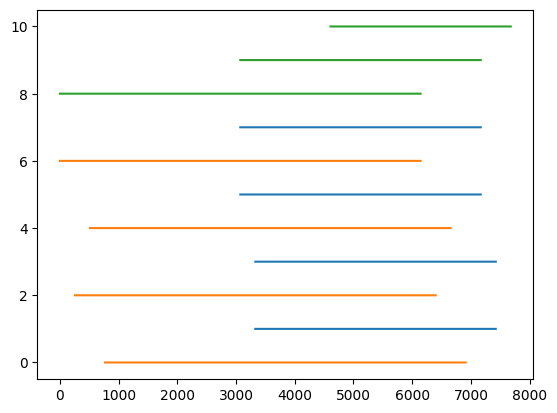

In [18]:
ts = np.ones(int(2048*3.75))
x = np.arange(0, int(2048*3.75), 1)
elevation = 0
for i in range(len(templates)):
    plt.plot(x[templates[i][1]], elevation*ts[templates[i][1]], color = 'C1')
    elevation +=1
    plt.plot(x[templates[i][0]], elevation*ts[templates[i][0]], color = 'C0')
    elevation +=1
plt.plot(np.arange(0, 2048*3, 1), elevation*np.ones(int(2048*3)), color = 'C2')
elevation +=1
plt.plot(np.arange(2048*1.5, 2048*3.5, 1), elevation*np.ones(int(2048*2)), color = 'C2')
elevation +=1
plt.plot(np.arange(2048*2.25, 2048*3.75, 1), elevation*np.ones(int(2048*1.5)), color = 'C2')

In [10]:
X = whitener[-1](batch[0][..., int(-(fft_kernel_length+fduration)*sample_rate):], batch[2])
X_fft = torch.fft.rfft(X)
freqs = torch.fft.rfftfreq(
    X.shape[-1], d=1 / sample_rate
)
mask = freqs >= fft_high_pass
mask *= freqs <= fft_low_pass
X_fft = X_fft[:, :, mask]
freqs = np.linspace(0, sample_rate/2, batch[2].shape[-1])
mask = freqs >= fft_high_pass
mask *= freqs <= fft_low_pass
asds = (batch[2][:, :, mask]**0.5 * 1e23).float()
if asds.shape[-1] != X_fft.shape[-1]:
    asds = F.interpolate(asds, size=(X_fft.shape[-1],), mode="linear", align_corners=False)
X_fft = torch.cat((X_fft.real, X_fft.imag, 1/asds), dim=1)
X = tuple()
sliced_waveforms = batch[0][..., int(-(kernel_lengths[0]+fduration)*sample_rate):]
X = X + (resampler[0](whitener[0](sliced_waveforms, batch[2])),)
template_samples = random.choices(templates, k = batch_size)
for band, kl in enumerate(kernel_lengths[1:]):
    sliced_waveforms = torch.stack([batch[0][i, :, width] for i, width in enumerate([template[band] for template in template_samples])])
    X = X + (resampler[band+1](whitener[band+1](sliced_waveforms, batch[2])),)
X = X + (X_fft,)

In [11]:
clean_X = whitener[-1](batch[0], batch[2])
batch_iter = iter(range(batch_size))

In [12]:
for i in range(4):
    print(X[i].shape)

torch.Size([100, 2, 1024])
torch.Size([100, 2, 1024])
torch.Size([100, 2, 1024])
torch.Size([100, 6, 993])


tensor([1.])


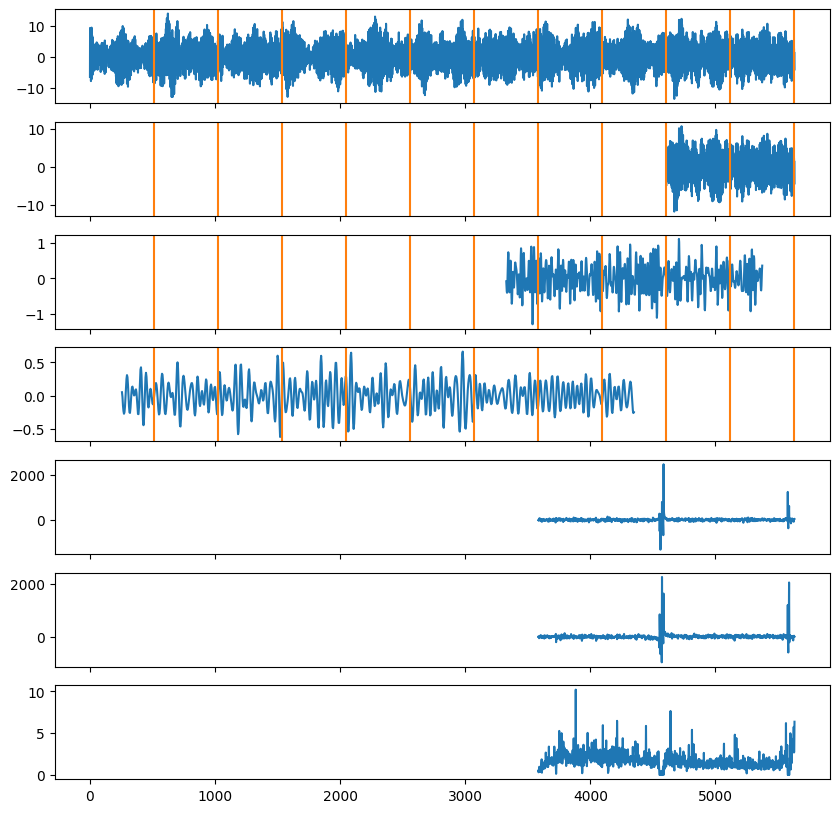

In [26]:
i = next(batch_iter)
print(batch[1][i])
fig, axs = plt.subplots(figsize = (10, 10), nrows = 7, sharex = True)
axs[0].plot(np.arange(0, clean_X.shape[-1], 1), clean_X[i][0])
for band, rr in enumerate(resample_rates):
    fraction = sample_rate/rr
    if band == 1 or band == 2:
        if template_samples[i][band-1].stop == None:
            plotx = np.arange(clean_X.shape[-1]-kernel_lengths[band]*sample_rate, clean_X.shape[-1], fraction)
            axs[band+1].plot(plotx, X[band][i][0])
        else:
            plotx = np.arange(clean_X.shape[-1]+template_samples[i][band-1].start+fduration*sample_rate, 
                              clean_X.shape[-1]+template_samples[i][band-1].stop, 
                              fraction)
            axs[band+1].plot(plotx, X[band][i][0])
    else:
        axs[band+1].plot(np.arange(clean_X.shape[-1]-kernel_lengths[0]*sample_rate, clean_X.shape[-1], fraction), X[band][i][0])
axs[4].plot(np.linspace(clean_X.shape[-1]-fft_kernel_length*sample_rate, clean_X.shape[-1], len(X[-1][i][0])), X[-1][i][0])
axs[5].plot(np.linspace(clean_X.shape[-1]-fft_kernel_length*sample_rate, clean_X.shape[-1], len(X[-1][i][0])), X[-1][i][2])
axs[6].plot(np.linspace(clean_X.shape[-1]-fft_kernel_length*sample_rate, clean_X.shape[-1], len(X[-1][i][0])), X[-1][i][4])
for i in range(4):
    axs[i].axvline(512, color = 'C1')
    axs[i].axvline(512*2, color = 'C1')
    axs[i].axvline(512*3, color = 'C1')
    axs[i].axvline(512*4, color = 'C1')
    axs[i].axvline(512*5, color = 'C1')
    axs[i].axvline(512*6, color = 'C1')
    axs[i].axvline(512*7, color = 'C1')
    axs[i].axvline(512*8, color = 'C1')
    axs[i].axvline(512*9, color = 'C1')
    axs[i].axvline(512*10, color = 'C1')
    axs[i].axvline(512*11, color = 'C1')

In [27]:
TDSAD.trainer.training = False
TDSAD.trainer.validating = True
ds = TDSAD.val_dataloader()
for val_batch in ds:
    val_batch = TDSAD.on_before_batch_transfer(val_batch, 10)
    break

In [28]:
[background, _, timeslide_idx], [signals] = val_batch
shift = TDSAD.timeslides[timeslide_idx].shift_size

In [29]:
X_bg, X_inj, psds = TDSAD.build_val_batches(background, signals)

In [30]:
X_bg.shape

torch.Size([100, 2, 7680])

In [36]:
X_fg_fft = []
for inj in X_inj:
    inj = whitener[-1](inj[..., int(-(fft_kernel_length+fduration)*sample_rate):], psds)
    freqs = torch.fft.rfftfreq(
        inj.shape[-1], d=1 / sample_rate
    )
    inj = torch.fft.rfft(inj)
    mask = freqs >= fft_high_pass
    mask *= freqs <= fft_low_pass
    inj = inj[:, :, mask]
    X_fg_fft.append(inj)

X_fg_fft = torch.stack(X_fg_fft)

X_bg_fft = whitener[-1](X_bg[..., int(-(fft_kernel_length+fduration)*sample_rate):], psds)
freqs = torch.fft.rfftfreq(
        X_bg_fft.shape[-1], d=1 / sample_rate
)
X_bg_fft = torch.fft.rfft(X_bg_fft)
mask = freqs >= fft_high_pass
mask *= freqs <= fft_low_pass
X_bg_fft = X_bg_fft[..., mask]

freqs = np.linspace(0, sample_rate/2, psds.shape[-1])
mask = freqs >= fft_high_pass
mask *= freqs <= fft_low_pass
asds = (psds[:, :, mask]**0.5 * 1e23).float()

if asds.shape[-1] != X_fg_fft.shape[-1]:
    asds = F.interpolate(asds, size=(X_fg_fft.shape[-1],), mode="linear", align_corners=False)

X_bg_fft = torch.cat((X_bg_fft.real, X_bg_fft.imag, 1/asds), dim=1)
asds = asds.unsqueeze(dim = 0).repeat(num_valid_views,1,1,1)
X_fg_fft = torch.cat((X_fg_fft.real, X_fg_fft.imag, 1/asds), dim=2)

bg = tuple()
fg = tuple()
fraction = resample_rates[0]/sample_rate
X_bg_bp = whitener[0](X_bg[..., int(-(kernel_lengths[0]+fduration)*sample_rate):], psds)
shape = X_bg_bp.shape
X_bg_bp = resampler[0](X_bg_bp.reshape(shape[0]*shape[1], shape[2])).reshape(shape[0], shape[1], int(fraction*shape[2]))
# whiten each view of injections
X_fg_bp = []
for inj in X_inj:
    inj = whitener[0](inj[..., int(-(kernel_lengths[0]+fduration)*sample_rate):], psds)
    shape = inj.shape
    inj = resampler[0](inj.reshape(shape[0]*shape[1], shape[2])).reshape(shape[0], shape[1], int(fraction*shape[2]))
    X_fg_bp.append(inj)
    
X_fg_bp = torch.stack(X_fg_bp)
bg = bg + (X_bg_bp,)
fg = fg + (X_fg_bp,)
template_samples = random.choices(templates, k = batch_size)
for band, kl in enumerate(kernel_lengths[1:]):
    fraction = resample_rates[band+1]/sample_rate
    X_bg_bp = torch.stack([X_bg[i, :, width] for i, width in enumerate([template[band] for template in template_samples])])
    X_bg_bp = whitener[band+1](X_bg_bp, psds)
    shape = X_bg_bp.shape
    X_bg_bp = resampler[band+1](X_bg_bp.reshape(shape[0]*shape[1], shape[2])).reshape(shape[0], shape[1], int(fraction*shape[2]))
    # whiten each view of injections
    X_fg_bp = []
    for inj in X_inj:
        inj = torch.stack([inj[i, :, width] for i, width in enumerate([template[band] for template in template_samples])])
        inj = whitener[band+1](inj, psds)
        shape = inj.shape
        inj = resampler[band+1](inj.reshape(shape[0]*shape[1], shape[2])).reshape(shape[0], shape[1], int(fraction*shape[2]))
        X_fg_bp.append(inj)
        
    X_fg_bp = torch.stack(X_fg_bp)
    bg = bg + (X_bg_bp,)
    fg = fg + (X_fg_bp,)
bg = bg + (X_bg_fft,)
fg = fg + (X_fg_fft,)

In [37]:
for i in range(4):
    print(bg[i].shape)
    print(fg[i].shape)

torch.Size([100, 2, 1024])
torch.Size([5, 100, 2, 1024])
torch.Size([100, 2, 1024])
torch.Size([5, 100, 2, 1024])
torch.Size([100, 2, 1024])
torch.Size([5, 100, 2, 1024])
torch.Size([100, 6, 993])
torch.Size([5, 100, 6, 993])
